In [1]:
%%sh
pip install torch -q 
pip install ipywidgets -q

In [2]:
import os
import sys
import data

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

from collections import OrderedDict

In [3]:
def uint82bin(n, count=8):
    """returns the binary of integer n, count refers to amount of bits"""
    return ''.join([str((n >> y) & 1) for y in range(count - 1, -1, -1)])

def labelcolormap(N):
    cmap = np.zeros((N, 3), dtype=np.uint8)
    for i in range(N):
        r, g, b = 0, 0, 0
        id = i + 1  # let's give 0 a color
        for j in range(7):
            str_id = uint82bin(id)
            r = r ^ (np.uint8(str_id[-1]) << (7 - j))
            g = g ^ (np.uint8(str_id[-2]) << (7 - j))
            b = b ^ (np.uint8(str_id[-3]) << (7 - j))
            id = id >> 3
        cmap[i, 0] = r
        cmap[i, 1] = g
        cmap[i, 2] = b

    
    cmap[0] = (255, 255, 255)

    return cmap

In [4]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


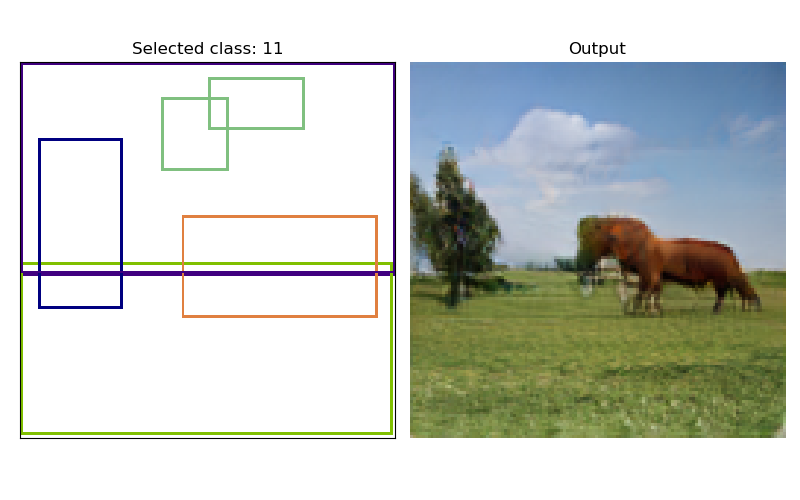

Button(description='Resample', style=ButtonStyle())

Button(description='Save as image', style=ButtonStyle())

Button(description='Reset', style=ButtonStyle())

In [7]:
%matplotlib notebook

# adapted from https://github.com/dariopavllo/style-semantics

import json
import matplotlib
from matplotlib.widgets import TextBox, Button
from ipywidgets import interact, interactive, fixed, interact_manual, HBox
import ipywidgets as widgets
import imageio

from demo.vg import sample
from utils.util_v2 import *

with open("./data/vocab.json", "r") as read_file:
    vocab = json.load(read_file)
    
version = 1
img_size = 128
    
label_nc = 178

label_names = vocab['object_idx_to_name']
attr_names = vocab['attribute_idx_to_name']

cmap_arr = labelcolormap(label_nc + 1)
cmap = matplotlib.colors.ListedColormap(cmap_arr/255)
semantic_buffer = torch.FloatTensor(1, label_nc, 256, 256).zero_()
if torch.cuda.is_available():
    semantic_buffer = semantic_buffer.cuda()
sem_buffer = torch.LongTensor(img_size, img_size).zero_()

im_buffer = np.zeros((img_size, img_size, 3), dtype=np.float32)

list_bbox = []
list_label = []
list_attr = []

im_size = 8
fig = plt.figure(2, figsize=(im_size, im_size/2+1))
plt.subplots_adjust(wspace=0, hspace=0.03)

plt.subplot(1, 2, 1)
plt.title('Mask')
mask_im = plt.imshow(sem_buffer, cmap=cmap, vmin=0, vmax=label_nc + 1)
plt.xticks([])
plt.yticks([])
ax = plt.gca()

plt.subplot(1, 2, 2)
plt.title('Output')
output_im = plt.imshow(im_buffer)
plt.axis('off')

fig.tight_layout()
plt.show()

current_class = 1

num_o = 31
thres = 2.0
z_obj = torch.from_numpy(truncted_random(num_o=num_o, thres=thres)).float()
z_im = torch.from_numpy(truncted_random(num_o=1, thres=thres)).view(1, -1).float()

def redraw():
    with torch.no_grad():
        global im_buffer
        global list_bbox, list_label, list_attr
        global z_obj, z_im

        im_buffer = sample(version=version, img_size=img_size,
                           bbox=list_bbox,
                           label=list_label,
                           attr=list_attr,
                           z_im=z_im, z_obj=z_obj, resample=False)
        im_buffer = (im_buffer * 0.5 + 0.5)
        output_im.set_data(im_buffer)

origin = None
def on_click(event):
    global origin
    x = int(event.xdata)
    y = int(event.ydata)
    origin = (x, y) 

prev_coords = None
def on_move(event):
    global prev_coords
    if event.inaxes and event.inaxes == ax and event.button in [1, 3]:
        x = int(event.xdata)
        y = int(event.ydata)
        
        temp_sem_buffer = sem_buffer.clone()
        
        temp_sem_buffer[origin[1]][origin[0]:x] = current_class
        temp_sem_buffer[y][origin[0]:x] = current_class
        for i in range(y - origin[1] + 1):
            temp_sem_buffer[origin[1] + i][origin[0]] = current_class           
            temp_sem_buffer[origin[1] + i][x] = current_class
        
        mask_im.set_data(temp_sem_buffer)
        prev_coords = (x, y)
        
def on_release(event):
    x, y = prev_coords
    sem_buffer[origin[1]][origin[0]:x] = current_class
    sem_buffer[y][origin[0]:x] = current_class
    for i in range(y - origin[1] + 1):
        sem_buffer[origin[1] + i][origin[0]] = current_class           
        sem_buffer[origin[1] + i][x] = current_class
    
    mask_im.set_data(sem_buffer)
    
    global list_bbox, list_label, list_dcolor, list_bgcolor, list_dstyle
    list_bbox.append([origin[0], origin[1], prev_coords[0]-origin[0], prev_coords[1]-origin[1]])
    list_label.append(current_class - 1)
    list_attr.append(current_attr)
    
    redraw()
    
def update_class(cl):
    global current_class
    current_class = label_names.index(cl)
    ax.set_title(f'Selected class: {current_class}')
    current_class += 1
    
def update_attr(attr):
    global current_attr
    current_attr = np.zeros([80])
    for a in attr:
        if a in attr_names:
            current_attr[attr_names.index(a)] = 1
        
def save_to_file(_):
    imageio.imwrite('saved_drawing_label.png', cmap_arr[sem_buffer])
    imageio.imwrite('saved_drawing_image.png', (im_buffer * 255).astype(np.uint8))
    ax.set_title(f'(!) Saved as saved_drawing_*.png')
    
def resample(_):
    global z_obj, z_im
    z_obj = torch.from_numpy(truncted_random(num_o=num_o, thres=thres)).float()
    z_im = torch.from_numpy(truncted_random(num_o=1, thres=thres)).view(1, -1).float()
    redraw()
    
def reset(_):
    sem_buffer.zero_()
    mask_im.set_data(sem_buffer)
    
    global list_bbox, list_label, list_attr
    list_bbox = []
    list_label = []
    list_attr = []
    
    global im_buffer
    im_buffer = np.zeros((img_size, img_size, 3), dtype=np.float32)
    output_im.set_data(im_buffer)

fig.canvas.mpl_connect('button_press_event', on_click)
fig.canvas.mpl_connect('motion_notify_event', on_move)
fig.canvas.mpl_connect('button_release_event', on_release)

class_box = widgets.Select(options=[str(label_names[x]) for x, y in enumerate(label_names)],
                           description='Class')

attr_box = widgets.SelectMultiple(options=[attr_names[x] for x, y in enumerate(attr_names)],
                                  description='Attributes')


resample_button = widgets.Button(description='Resample')
resample_button.on_click(resample)
save_button = widgets.Button(description='Save as image')
save_button.on_click(save_to_file)
reset_button = widgets.Button(description='Reset')
reset_button.on_click(reset)

i_class = interactive(update_class, cl=class_box)
i_attr= interactive(update_attr, attr=attr_box)

display(resample_button)
display(HBox([i_class, i_attr]))

display(save_button, reset_button)